In [315]:
import os 
from dotenv import load_dotenv
load_dotenv()


True

In [316]:
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings

llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash', google_api_key = os.getenv('GEMINI_KEY'))
embedding_function = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001",  # Correct embedding model
    google_api_key=os.getenv('GEMINI_KEY')
)

In [317]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode


In [318]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

In [394]:
docs  =[WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap = 25)
final_docs = text_splitter.split_documents(docs_list)

vectordb = Chroma.from_documents(documents=final_docs, collection_name="rag-chroma", embedding=embedding_function)
retriver = vectordb.as_retriever()

In [395]:
retriver_tool = create_retriever_tool(
    retriver,
    "retrive_blog_post",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response."
)
retriver_tool


Tool(name='retrive_blog_post', description="Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.", args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x78ea5364af80>, retriever=VectorStoreRetriever(tags=['Chroma', 'GoogleGenerativeAIEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x78e9e58d3010>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function

In [396]:
tools = [retriver_tool]



In [397]:
retrieve=ToolNode([retriver_tool])

In [398]:
retriver_tool.invoke("what is the agent")

'Agents”. Lil’Log. https://lilianweng.github.io/posts/2023-06-23-agent/.\n\nAgents”. Lil’Log. https://lilianweng.github.io/posts/2023-06-23-agent/.\n\nAgents”. Lil’Log. https://lilianweng.github.io/posts/2023-06-23-agent/.\n\nAgents”. Lil’Log. https://lilianweng.github.io/posts/2023-06-23-agent/.'

In [399]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage], add_messages]

In [400]:
def ai_assistant(state:AgentState):
    print("---CALL AGENT---")
    print(f'------state received ----{state}')
    messages = state['messages']
    print(f'----messgaes----{messages}')
    
    if len(messages)>1:
        last_message = messages[-1]
        question = last_message.content
        prompt=PromptTemplate(
        template="""You are a helpful assistant whatever question has been asked to find out that in the given question and answer.
                        Here is the question:{question}
                        """,
                        input_variables=["question"]
                        )
            
        chain = prompt | llm
    
        response=chain.invoke({"question": question})
        return {"messages": [response]}
    else:
        llm_with_tool = llm.bind_tools(tools)
        response = llm_with_tool.invoke(messages)
        print(f'-------resposne------{response}')
        #response=handle_query(messages)
        return {"messages": [response]}
        

In [401]:
class grade(BaseModel):
    binary_score:str=Field(description="Relevance score 'yes' or 'no'")

In [402]:
def grade_documents(state:AgentState)->Literal["Output_Generator", "Query_Rewriter"]:
    llm_with_structure_op=llm.with_structured_output(grade)
    print(f'-----state received ----{state}')
    
    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
    chain = prompt | llm_with_structure_op
    
    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator" #this should be a node name
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter" #this should be a node name

In [403]:
def generate(state:AgentState):
    print("---GENERATE---")
    messages = state["messages"]

    question = messages[0].content
    
    last_message = messages[-1]
    docs = last_message.content
    
    prompt = hub.pull("rlm/rag-prompt")
    
    rag_chain = prompt | llm

    response = rag_chain.invoke({"context": docs, "question": question})
    print(f"this is my response:{response}")
    
    return {"messages": [response]}

In [404]:
from langchain_core.messages import  HumanMessage
def rewriter(state:AgentState):
    print("----transform query----")
    messages = state["messages"]
    question = messages[0].content 

    message = [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """)
       ]
    response = llm.invoke(message)
    print(f'-----the transformed query----{response}')
    return {"messages":[response]}



In [424]:
workflow =  StateGraph(AgentState)
workflow.add_node("ai_assistance", ai_assistant)
workflow.add_node('retriver', ToolNode([retriver_tool]))
workflow.add_node('Output_Generator',generate)
workflow.add_node("Query_Rewriter", rewriter)

In [425]:
workflow.add_edge(START, "ai_assistance")

In [426]:
workflow.add_conditional_edges(
    "ai_assistance", 
    tools_condition,
    {"tools":"retriver", END:END}
)


In [427]:

workflow.add_conditional_edges(
    "retriver",
    grade_documents,
    {'generator':"Output_Generator",
     'rewriter':'Query_Rewriter'
     }

    )

In [428]:

workflow.add_edge('Output_Generator', END)

In [429]:




workflow.add_edge('Query_Rewriter','ai_assistance' )


In [430]:
app = workflow.compile()



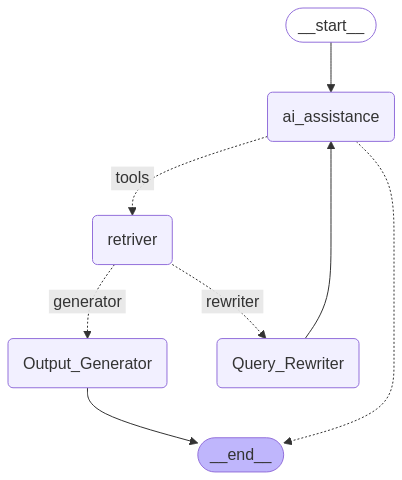

In [431]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [432]:

app.invoke({"messages":["what is capital of india?"]})

---CALL AGENT---
------state received ----{'messages': [HumanMessage(content='what is capital of india?', additional_kwargs={}, response_metadata={}, id='b6cdc091-cd08-4fa1-8d10-7188e64cf18f')]}
----messgaes----[HumanMessage(content='what is capital of india?', additional_kwargs={}, response_metadata={}, id='b6cdc091-cd08-4fa1-8d10-7188e64cf18f')]
-------resposne------content='New Delhi' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run-a4cb5042-70b1-4b0a-925d-ca58543ab0c1-0' usage_metadata={'input_tokens': 106, 'output_tokens': 3, 'total_tokens': 109, 'input_token_details': {'cache_read': 0}}


{'messages': [HumanMessage(content='what is capital of india?', additional_kwargs={}, response_metadata={}, id='b6cdc091-cd08-4fa1-8d10-7188e64cf18f'),
  AIMessage(content='New Delhi', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-a4cb5042-70b1-4b0a-925d-ca58543ab0c1-0', usage_metadata={'input_tokens': 106, 'output_tokens': 3, 'total_tokens': 109, 'input_token_details': {'cache_read': 0}})]}